# Classification & Regression part 2


### Setting up the Notebook

In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


from src.linear import MyLinearRegression

## 1 Implementing Linear Regression (20 Points)

#### Creating Some Toy Data for Testing & Debugging

The following toy data is CSI example used in the lecture, where the goal is to estimate a person's height based on the size of a shoe print. So 20 (shoe print size, height)-pairs have been collected.

In [3]:
data = np.array([
    (31.3, 180.3), (29.7, 175.3), (31.3, 184.8), (31.8, 177.8),
    (31.4, 182.3), (31.9, 185.4), (31.8, 180.3), (31.0, 175.5),
    (29.7, 177.8), (31.4, 185.4), (32.4, 190.5), (33.6, 195.0),
    (30.2, 175.3), (30.4, 180.3), (27.6, 172.7), (31.8, 182.9),
    (31.3, 189.2), (34.5, 193.7), (28.9, 170.3), (28.2, 173.8)
])

X = data[:,0].reshape(-1, 1)
y = data[:,1].reshape(-1, 1)

We can visualize the data using a simple scatter plot.

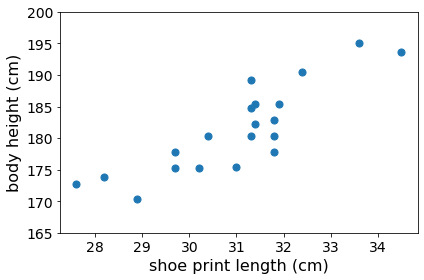

In [4]:
plt.figure()
axes = plt.axes()
axes.set_ylim([165, 200])
plt.tick_params(labelsize=14)
plt.scatter(X, y, s=50)
plt.xlabel('shoe print length (cm)', fontsize=16)
plt.ylabel('body height (cm)', fontsize=16)
plt.tight_layout()
plt.show()

The plot shows that there is a reasonably good linear relation ship between the shoe print size and the height of a person. Hence one can justifiably use Linear Regression to find a good fit of the data.

### 1.1 Add Bias Terms  to Data Matrix (2 Points)

In the lecture, we saw that solving Linear Regression is best done using matrix and vector representation of the different components $X$, $y$, and $\theta$. This required to add a constant term $x_0=1$ to the data matrix $X$ to reflect the bias/intercept term $\theta_0$; see the example below.

$$ 
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1d}  \\
x_{21} & x_{22} & \dots & x_{2d}  \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nd}  \\
\end{bmatrix} \quad \Rightarrow \quad
X = 
\begin{bmatrix}
1 & x_{11} & x_{12} & \dots & x_{1d}  \\
1 & x_{21} & x_{22} & \dots & x_{2d}  \\
1 & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \dots & x_{nd}  \\
\end{bmatrix}
$$


**Implement the methods `add_bias()`** that adds the constant terms to each sample in the data matrix $X$ as shown above! (Hint: numpy provides a whole range of methods for creating and concatenating vectors/matrices, which makes it very simple. There should be no need for any loops.)

You can test your implementation using the code below.

In [5]:
linreg = MyLinearRegression()

X_with_bias = linreg.add_bias(X)

print(X_with_bias)

[[ 1.  31.3]
 [ 1.  29.7]
 [ 1.  31.3]
 [ 1.  31.8]
 [ 1.  31.4]
 [ 1.  31.9]
 [ 1.  31.8]
 [ 1.  31. ]
 [ 1.  29.7]
 [ 1.  31.4]
 [ 1.  32.4]
 [ 1.  33.6]
 [ 1.  30.2]
 [ 1.  30.4]
 [ 1.  27.6]
 [ 1.  31.8]
 [ 1.  31.3]
 [ 1.  34.5]
 [ 1.  28.9]
 [ 1.  28.2]]


The output should look something like:
    
```
[[ 1.  31.3]
 [ 1.  29.7]
 [ 1.  31.3]
 ...
```

### 1.2 Train Model Using Normal Equation (6 Points)

We saw in the lecture that we can minimize the Mean Squared Error (MSE) loss $L$ of Linear Regression and therefore find the best values for $\theta$ analytically. We did so by finding the derivative of $L$ with respect to $\theta$, setting it to 0 and solving for $\theta$. We got the following formula called the **Normal Equation**:

$$\theta = X^{\dagger}y, \ with\ X^{\dagger} = (X^TX)^{-1} X^T$$

where $X^{\dagger}$ is the *pseudo inverse* of matrix $X$

**Implement the method `fit_analytically()` that solves this equation!** (Have look at [`np.dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) and [`numpy.linalg.inv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html) to make your life easier)

You can test your implementation using the code below. Note that we use `X` instead of `X_with_bias`, since `fit_analytically()` calls `add_bias()`. The result should match the ones shown in the lecture slides as we're using the same example dataset here.

In [6]:
linreg = MyLinearRegression()

linreg.fit_analytically(X, y)

theta_best = linreg.theta

print('The theta values that minmized the loss for your CSI example are: {}'.format(theta_best.squeeze()))

The theta values that minmized the loss for your CSI example are: [69.45528793  3.61092267]


We can also calculate the optimal loss, i.e., the loss given the best values for $\theta$

In [7]:
# Predict the output values for all data samples
y_pred = np.dot(X_with_bias, theta_best)

# Calculate loss
best_loss = linreg.loss(y, y_pred)

print('The loss for the best values of theta is: {:.3f}'.format(best_loss))

The loss for the best values of theta is: 11.885


You should see are loss of around **11.9**.

### 1.3 Train Model Using Gradient Descent (12 Points)

Apart from using the Normal Equation for fitting a Linear Regression model, we also introduced Gradient Descent. Here, instead of setting the $\nabla_\theta L$ to ) and solving for $\theta$, we start with initial parameter values for $\theta$, calculate the respective gradient, and update $\theta$ to reduce the loss $L$ iteratively.

The gradient for loss $L$ w.r.t. to $\theta$ is given as:

$$\nabla_\theta L = \frac{2}{n} X^T(X\theta - y)$$


#### 1.3 a) Calculating the Gradient (4 Points)

**Implement the methods `calc_h()` and `calc_gradient()` to calculate the gradient!** The only reason to have 2 methods for this is that it allows us to re-use some code (see method `predict()` that uses `calc_h()`)

In [8]:
linreg = MyLinearRegression()

# Initialize theta (again, we use the example values from the lecture)
linreg.theta = np.array([60, 4]).reshape(-1, 1)

h = linreg.calc_h(X_with_bias)

grad = linreg.calc_gradient(X_with_bias, y, h)

print('The gradient for theta = {} is: {}'.format(linreg.theta.squeeze(), grad.squeeze()))

The gradient for theta = [60  4] is: [  5.22  163.914]


Since we use the same data and values for $\theta$ as in the lecture, the gradient should match again the result on the slides.

#### 1.3 b) Implementing Gradient Descent (4 Points)

We now have everything place to implement the training loop for Gradient Descent.

**Implement the method `fit()` to find the best $\theta$ using Gradient Descent!** Most of the code is give, so you can focus on the loop that performs Gradient Descent.

You can test your implementation using the code below. With the parameters given (`lr=0.00001`, `num_iter=1000`), you should be able to achieve a loss below 25.0 for the CSI example.

In [9]:
linreg = MyLinearRegression()

linreg.fit(X, y, lr=0.00001, num_iter=1000)

Loss: 32962.942 	 0%
Loss: 692.523 	 10%
Loss: 38.471 	 20%
Loss: 25.215 	 30%
Loss: 24.946 	 40%
Loss: 24.940 	 50%
Loss: 24.940 	 60%
Loss: 24.940 	 70%
Loss: 24.940 	 80%
Loss: 24.940 	 90%
Loss: 24.940 	 100%


#### 1.3 c) Hyperparameter Tuning "By Hand" (4 Points)

Seeing the loss going down and reaching a value below 25.0 (with the example parameter values above) is a good start. However, we already know that the optimal loss is around 11.9 (see Section 1.2). Of course, we could simply increase the value of `num_iter` more and more, knowing that at some point Gradient Descent will reach the minimum. But this would  unnecessarily increase the computation time.

**Evaluate different values for the learning rate `lr` and the number of iterations `num_iter`!** In more detail:

* Find a setting for both parameters that will reduce the loss below 12.0
* Find such a setting as to keep `num_iter` as small as possible
* Discuss any interesting observations you have made while find such a parameter setting (e.g., how the development of the loss behaves, limitations on the choice of parameter values, etc.) together with a brief explanation

(Hint: You don't have to make fine-grained changes to the parameters. For example, there's no point to increase `num_iter` from 1000 to 1001 :). Start with changing the order of magnitude of the parameter values and maybe try some finer changes.)

**Your answer** (identified parameter values)

In [ ]:
my_lr = 0.001
my_num_iter = 436000

**Your answer** (interesting observations)

1. Learning rate is critical. learning rate larger than 0.001, such as 0.0011 or 0.0012, it will never converge, the loss will be extremely large and will even result in output errors. When learning rate is too low, such as 0.0001, it will be too low to converge.
2. It's still slow to converge after adjusting learning rate, only starts to reaching optimal solution after 20k iterations(loss = 13.4), and it seems to be 'near-plateau'
3. When learning rate is large enough, in this case 0.001, the adjusting becomes very agile, for instance adjust learning rate from 0.001 to 0.0011 the cost oscillates up.

### Predicting Output Values

With the code you implemented you can already perform predictions. The method `predict()` only wraps the required steps to provide a clean interface. We therefore just give it to you; there's nothing more for you to implement here. Below is just the example prediction from the CSI example.

In [10]:
# The predicted value depends on the values of theta.
# To ensure a consistent results, let's use the best theta.
linreg.fit_analytically(X, y)

X_suspect = np.array([[32.2]])

y_suspect_pred = linreg.predict(X_suspect)

print('The estimated height of the suspect is: {:.1f} cm'.format(y_suspect_pred.squeeze()))

The estimated height of the suspect is: 185.7 cm


The result should be 185.7 cm.

------------------------------------------------

## 2 Logistic Regression (10 Points)

Logistic Regression is a linear model for classification tasks. It's call Logistic *Regression* because the output is a real value. However, this value is interpreted as a probability whether the input sample belongs to class 0 or 1 -- we are only considering Logistic Regression for binary classification here.

Since Linear and Logistic Regression are inherently related, there is no need to also implement Logistic Regression for this assignment as well. This section focuses therefore only on the differences between the two methods.

### 2.1 Identifying the Required Changes (2 Points)

The class `MyLinearRegression` has 7 methods, ignoring the `__init__()` method. If we want to implement our own class `MyLogisticRegression`, we can utilize the close relationship between Linear and Logistic Regression to simplify this task. In fact, both implementation will look very similar.

**Which of the 7 methods can be REMOVED, can remain UNCHANGED, or have to be CHANGED** for implementing Logistic Regression? 

*Methods that can be removed*

* fit_analytically


*Methods that can remain unchanged*

* \_\_init\_\_
* add_bias
* fit

*Methods that need to be changed*

* calc_h
* loss
* calc_gradient
* predict


### 2.2 Making the Required Changes (8 Points)

**For all the methods that need to be changed, show how they need to be changed!** You are free to do this task in two ways:

* **Option A:** Implement to methods using the code cell below (you don't have to test your code and it may contain little syntax errors as along as the steps/calculations are clear; you may add comments as well, of course) **OR**
* **Option B:** Describe how the methods need to be changed in the Markdown cell below (please be provide sufficient detail to make the required changes and new calculations clear)

**Option A -- Your answer in Python code:**

In [ ]:
#########################################################################################
### Your code starts here ############################################################### 
def calc_h(self, X):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    h = np.dot(X, self.theta)
    h = sigmoid(h)
    return h

def loss(self, h, y):
    #Find loss for all training samples
    #Cross-Entropy Loss
    n = y.shape[0]
    loss = -(1/n) * np.sum(y * np.log(h) + (1-y) * np.log(1 - h))
    return loss

def calc_gradient(self, X, y, h):
    errors = np.subtract(h, y) # h: after sigmoid
    n = X.shape[0]
    grad = (1/n) * np.dot(X.transpose(), errors)
    return grad

    
def predict(self, X):

    X = self.add_bias(X)

    decision = lambda x: 1 if x >= 0.5 else 0 # classify 0(False) or 1(True)
    predictions = self.calc_h(X)

    return np.vectorize(decision)(predictions).flatten()

### Your code ends here #################################################################
#########################################################################################  

**Option B -- Your answer in plain text:**

------------------------------------------------------

## 3 Model Selection (20 Points)

The topic "Classification & Regression" covered a whole series of different models. In this section, look at the basic data mining task of find the best model for a given dataset: which model performs best with which hyperparameters. To keep it simple and keep the implementation work to a minimum, we make full use of scikit-learn (see additional hints in the subtasks).

#### Prepare Dataset

The [Digit Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) is made up of 1,797 8x8 pixel images. Each image is of a hand-written digit. We use this dataset since it basically does not require any data preprocessing as all features are numerical and there are no "dirty" records. We only normalize the data via standardization (see the code cell below).

In [11]:
digits = load_digits()

X, y = digits.data, digits.target

# Split dataset in training and test data (20% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalize data using the sciki-learn StandardScaler
scaler = StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

print('Number of features: {}'.format(X_train.shape[1]))
print('Number of samples for training: {}'.format(X_train.shape[0]))
print('Number of samples for testing: {}'.format(X_test.shape[0]))

Number of features: 64
Number of samples for training: 1437
Number of samples for testing: 360


### 3.1 Basic Model Evaluation (7 Points)

For all following tasks, we use scitki-learn implementations of the models we covered in the module:

* [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

* [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

* [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

* [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

* [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) with (`base_estimator=DecisionTreeClassifier()`)

* [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)




**3.1 a) Train 6 classification models using the available scikit-learn implementations! (4 Points)** Use each model with its default parameters! We leave any tuning for 3.2. (Hint: You can basically copy/adopt the relevant lines from A2a, Task 2.2. You might want to train each model in its own code cell to make the timing of the runtime easier.)

Another hint: As the dataset is rather small, most models will train rather quickly. The get a better sense of the runtime of each implementation, you can train the same model multiple times in a loop to get an aggregated runtime, something like:

```
for _ in range (100):
    # Train Decision Tree
```

This should make it a bit easier to compare the different models w.r.t. to their runtime.

In [12]:
%%time

clf_knn, clf_logreg, clf_dtree, clf_rforest, clf_adaboost, clf_gbtree = None, None, None, None, None, None

#########################################################################################
### Your code starts here ############################################################### 
for _ in range (100):
    clf_knn = KNeighborsClassifier().fit(X_train, y_train)



CPU times: user 17.1 ms, sys: 4.27 ms, total: 21.4 ms
Wall time: 26.8 ms


In [13]:
%%time
for _ in range (100):
    clf_logreg = LogisticRegression().fit(X_train, y_train)

CPU times: user 56.9 s, sys: 15.1 s, total: 1min 11s
Wall time: 10.2 s


In [14]:
%%time
for _ in range (100):
    clf_dtree = DecisionTreeClassifier().fit(X_train, y_train)

CPU times: user 1.03 s, sys: 8.13 ms, total: 1.04 s
Wall time: 1.04 s


In [15]:
%%time
for _ in range (100):
    clf_rforest = RandomForestClassifier().fit(X_train, y_train)

CPU times: user 15.7 s, sys: 99.4 ms, total: 15.8 s
Wall time: 15.8 s


In [16]:
%%time
for _ in range (100):
    clf_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()).fit(X_train, y_train)

CPU times: user 1.11 s, sys: 6.96 ms, total: 1.11 s
Wall time: 1.11 s


In [17]:
%%time
for _ in range (100):
    clf_gbtree = GradientBoostingClassifier().fit(X_train, y_train)

### Your code ends here #################################################################
######################################################################################### 

CPU times: user 6min 58s, sys: 1.79 s, total: 7min
Wall time: 7min 1s


The following code simply prints the f1 scores for each model -- nothing to implement for you here!

In [18]:
print('F1 scores for test data for all classifiers')
print('===========================================')
for clf in [clf_knn, clf_logreg, clf_dtree, clf_rforest, clf_adaboost, clf_gbtree]:
    try:
        # Predict labels for test samples
        y_pred = clf.predict(X_test)
        # Calculate the f1 score
        f1 = f1_score(y_test, y_pred, average='macro')
    except Exception as e:
        # Handle exception (e.g., a classifier is still None)
        f1 = '---'
    # Print classifier name and the f1 score
    print('{}:\t{:.3}'.format(type(clf).__name__, f1))
    

F1 scores for test data for all classifiers
KNeighborsClassifier:	0.969
LogisticRegression:	0.963
DecisionTreeClassifier:	0.85
RandomForestClassifier:	0.983
AdaBoostClassifier:	0.853
GradientBoostingClassifier:	0.964


**3.1 b) Briefly discuss the results and the observations you made during the training! (3 Points)** You can refer to the runtime, f1 scores, or any other interesting or surprising observation you have made.

* Runtime: KNeighborsClassifier is fastest and GradientBoosting is significantly the slowest
* F1 score: RandomForest gives us the best F1 score
* KNeighborsClassifier performs quite well as it gives high F1 score with fastest runtime. 
* The F1 score of KNN is also good and even higher than GradientBoosting
* DecisionTree and AdaBoost does not perform well(their F1 scores are around 0.85), but their performance is quite similar (their F1 score is similar and runtime also quite close)
* LogisticRegression and GradientBoostingClassifier gives us similar F1 scores, while LogisticRegression is a lot faster than GradientBoosting

### 3.2 Hyperparameter Tuning (7 Points)

The results of the different models will vary quite a bit, but of course, we used the only default parameters of each implementation which might or might not be good for our dataset and task. In practice, you would perform hyperparameter tuning for all or at least most models. However, this is unnecessarily since the tuning process is very similar for each model. So we do it only for one model: **AdaBoost** (which shows a comparatively poor performance with the default values)

#### 3.2 a) Perform hyperparameter tuning for AdaBoost (using Decision Trees)! (4 Points)

**Important hints:**

* Use [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)! It automatically performs k-fold cross-validation (by default: k=5, which is fine) for all specified combinations of hyperparameter values. With [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), finding the best model (i.e., the model with the best hyperparameter models) should only require only very few lines of code!
* As we have 10 classes we rely on averaged f1 scores. Please use `scoring='f1_macro'` for [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)!
* [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) with (`base_estimator=DecisionTreeClassifier()`) provides a whole range of hyperparameters. Pick a **maximum of 3 hyperparameters** to tune the model!

In [35]:
%%time

model = None

#########################################################################################
### Your code starts here ###############################################################

param_grid = {
              'n_estimators': [10, 20, 30, 40, 50, 70, 100, 500, 1000], 
              'learning_rate': list(np.arange(0.1,1,0.1)) + [0.001, 0.005, 0.01, 0.1, 1], #list(np.arange(0.01,1,0.01)) + 
              'base_estimator__max_depth': [3,4,5] # 6, 7
             }
grid_search = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), param_grid=param_grid, n_jobs=-1, scoring='f1_macro')
model = grid_search.fit(X_train, y_train)

### Your code ends here #################################################################
######################################################################################### 

# Store the parameters of the best model
best_params = model.best_params_

# Predict class labels of test data on the model with the best found parameters
y_pred = model.predict(X_test)

# Calculate the f1 score
best_f1 = f1_score(y_test, y_pred, average='macro')

print('Best AdaBoost (with Decision Tree) classifier: {} (f1 score: {:.3f})'.format(best_params, best_f1))

Best AdaBoost (with Decision Tree) classifier: {'base_estimator__max_depth': 5, 'learning_rate': 0.7000000000000001, 'n_estimators': 1000} (f1 score: 0.979)
CPU times: user 9.62 s, sys: 1.21 s, total: 10.8 s
Wall time: 7min 2s


#### 3.2 b) Briefly discuss your process of finding the best hyperparameter values and the results (3 Points). 

Interesting points may include the choice of values for the grid search (and required changes), the improvements compared to the results for the default parameters in 3.1 a), the overall time required to find the best hyperparameter values, or any other interesting or surprising observations you have made during this task.

* I first grid search two key hyperparameters for AdaBoost: the number of trees used in the ensemble and the learning rate.
    * When finding best hyperparameter, such as learning_rate, I choose a coarse-grained first (e.g. step 0.1) and then refine in the better performing range (e.g. 0.001 in range 0.2-0.5).
    * Similarly for n_estimators, I start with (10, 50, 100, 1000) to see their performance, and find when n_estimators near 50 it performs best, so I also add (20,30, 40, 70) to compare.
* With the base_estimator set of DecisionTreeClassifier, adjust n_estimators and learning_rate, the improvement of performance is slight (compared to default parameters' score 0.853). 
    * If I don't tune hyperparameters for its base_estimator(decision tree, such as 'max_depth'), only with best parameters(learning_rate = 0.42 and n_estimators = 50) setting performs best with F1 score 0.869, not a good improvement from default parameters. So I add 'base_estimator__max_depth' to tune.
* After tuning the three hyperparameter, the model performs best with F1 score 0.979 (n_estimators = 1000, learning_rate = 0.7, base_estimator__max_depth = 5). So the improvement of performance is apparent compared to not tuning hyperparameter of base_estimator

### 3.3 Handling Overfitting (6 Points)

Suppose your model is experiencing low training error but high test error, i.e. overfitting. For each of the 6 methods listed in 3.1, select at least one of its hyperparameters (i.e. any input argument that could be passed to its scikit-learn implementation) and state how the hyperparameter could be modified to address the problem of overfitting. Add a brief(!) explanation to justify your choice!

*KNeighborsClassifier*:
* n_neighbors: represents the number of neighbors to use for kneighbors queries. Too small K makes predictions senstive to noise and has risk of overfitting. Increase n_neighbors can help address overfitting.(But too large K cannot capture local patterns and has risk of underfitting)

*LogisticRegression*:
* penalty: applys regularization, 'l2' in default. Logistic Regressions has risk of overfitting when we has many features, and it is necessary to use additional techniques, such as regularization, to tune the complexity of model.
* C: represents inverse of regularization strength. By decreasing the value of C we specify stronger regularization strength to address regularization. 

*DecisionTreeClassifier*:
* max_depth: pre-pruning, stop splitting if maximum depth of tree is reached. The deeper we allow our DecisionTree to grow, the more complex our model will become. And the decision tree will split perfectly for training data but not be able to generalize well for test data. Reduce the number of max depth of decision tree can help combat overfitting.

*RandomForestClassifier*:
* min_samples_split: represents the minimum number of samples required in a node to split. If the value is too small (such as 2 in default), the tree will keeps on splitting until all nodes are pure and grows in size, thus overfits the data. Increase min_samples_split will help address overfitting.

*AdaBoostClassifier*:
* n_estimators: represents the . Usually the higher n_estimators is the better to train the data. But although AdaBoost is fairly robust, when n_estimators is too large it may still result in overfitting(also slows down the training process), as it aims to minimize error on training set. Decreasing n_estimators to find the sweet spot may help address overfitting.

*GradientBoostingClassifier*:
* min_impurity_decrease: A node will only split if this split induces a decrease of impurity greater than or equals to this value. Threshold for early stopping, so increasing min_impurity_decrease will help avoid overfitting.
* min_samples_leaf: minimum number of samples required to be at a leaf node. Higher value ensures that the tree will not overfit the training data by being highly specific to one particular sample.
* max_depth: max depth of a tree. Decreasing max_depth to control overfitting.(reason similar to DecisionTree)
* max_features: represents the number of feature to consider when looking for split. If the features is too many 
